In [2]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [3]:
songs = ak.from_parquet("/home/jpivarski/storage/million-song-dataset/data-zstd.parquet", lazy=True)

<BarContainer object of 12 artists>

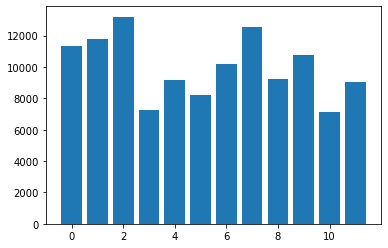

In [32]:
plt.bar(range(12), ak.sum(ak.sum(songs.analysis.segments.pitches[(songs.analysis.key_confidence > 0.9) & (songs.analysis.mode_confidence > 0.9) & (songs.analysis.mode == 1)], axis=1), axis=0))

In [5]:
key_shift = ak.Array([
    [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0],
    [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1],
    [ 3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2],
    [ 4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3],
    [ 5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4],
    [ 6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5],
    [ 7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6],
    [ 8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7],
    [ 9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8],
    [10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
    [11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
])

In [6]:
shift_for_song = key_shift[songs.analysis.key]

In [8]:
shifted_pitches = songs.analysis.segments.pitches[shift_for_song[:, np.newaxis]]

<BarContainer object of 12 artists>

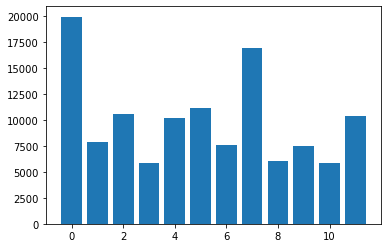

In [31]:
plt.bar(range(12), ak.sum(ak.sum(shifted_pitches[(songs.analysis.key_confidence > 0.9) & (songs.analysis.mode_confidence > 0.9) & (songs.analysis.mode == 1)], axis=1), axis=0))

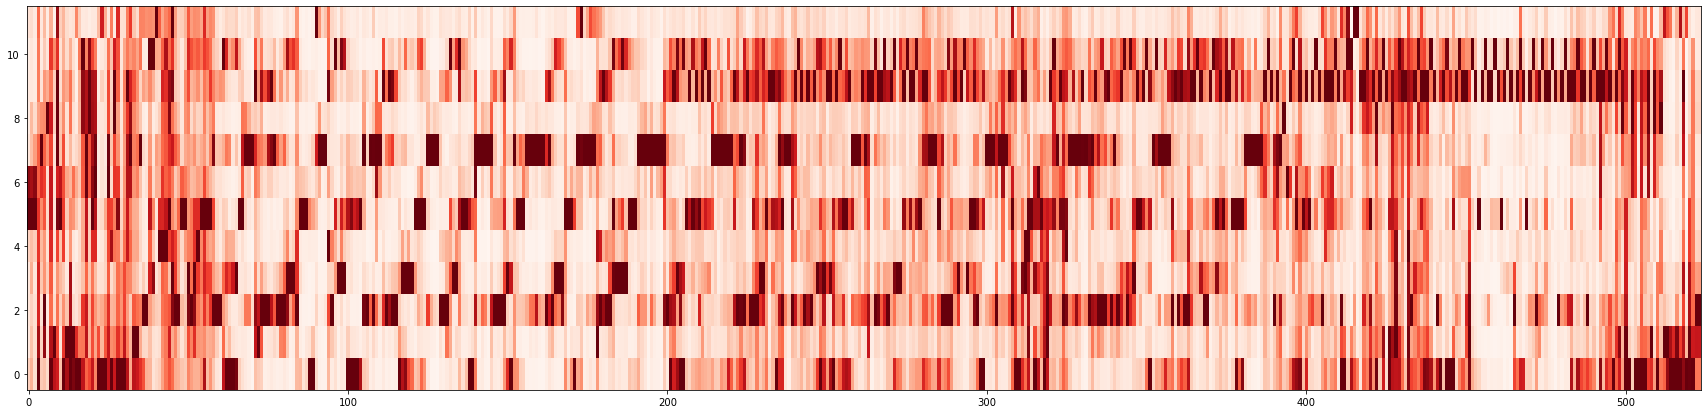

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
ax.imshow(np.asarray(songs.analysis.segments.pitches[(songs.metadata.artist_name == "Nine Inch Nails") & (songs.metadata.title == "The Frail")][0]).T, aspect=10, interpolation="nearest", cmap="Reds", origin="lower")

4

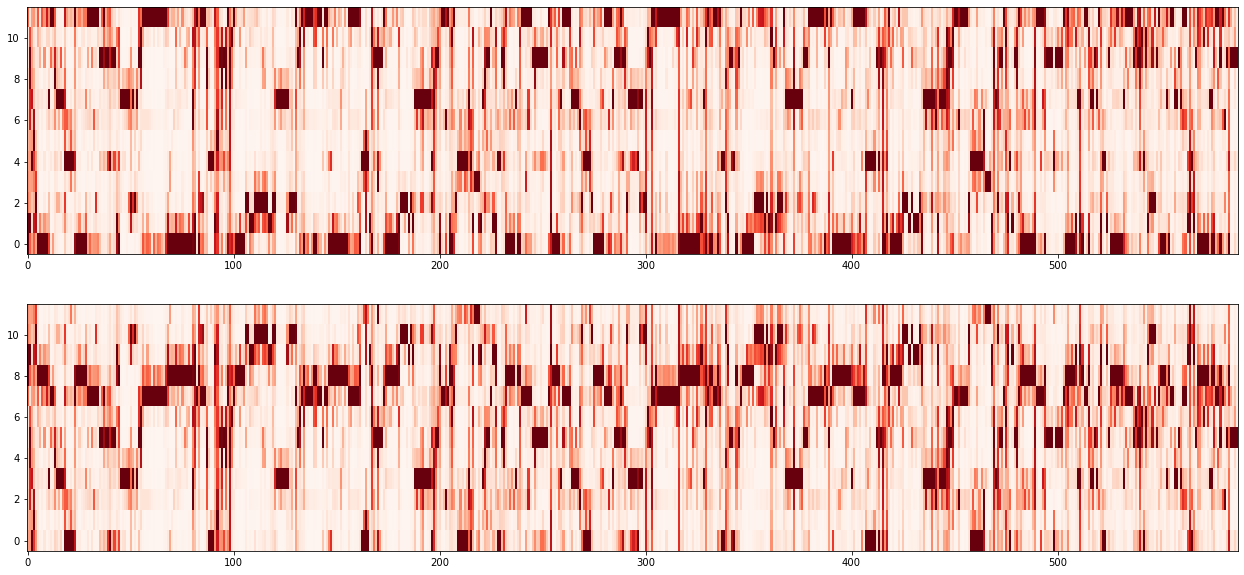

In [26]:
index = 7
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
ax1.imshow(np.asarray(songs.analysis.segments.pitches[index]).T, aspect=10, interpolation="nearest", cmap="Reds", origin="lower")
ax2.imshow(np.asarray(shifted_pitches[index]).T, aspect=10, interpolation="nearest", cmap="Reds", origin="lower")
songs.analysis.key[index]